## Import Packages

In [137]:
import copy
import os
import numpy as np
import pandas as pd
import zipfile
from simple_downloader import download
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader

# Training on UCMerced Dataset
## Download UCMerced Dataset from TUB-Cloud

Following workflow from Lab01, creating directory "./data", downloading UCMerced dataset zip-file and unzipping it.

In [67]:
download_dir = Path("./data")
download_dir.mkdir(exist_ok=True)
TUB_URL = "https://tubcloud.tu-berlin.de/s/H4QHX5GPDY6wDog/download/UCMerced_LandUse.zip"
output_file = download(TUB_URL, "./data/")
#Is Already extracted no need to do again
#zipf = zipfile.ZipFile(output_file)
#zipf.extractall(path="data")

Target file already exists!
Will skip download. To force download set `force=True`


In [68]:
mylabels = np.array(["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks", "trees","water"])

## Define Customized Dataset in PyTorch

In [69]:
class UCMerced(Dataset):
    def __init__(self, root_dir, img_transform=None, multilabel=False):

        self.root_dir = root_dir
        self.images_path = os.path.join(root_dir, "Images")
        self.class_names = sorted(
            [cl for cl in os.listdir(self.images_path) if not cl.startswith(".")]
        )
        self.img_paths, self.img_labels = self.init_dataset()
        self.img_transform = img_transform

        if multilabel:
            self.img_labels = self.read_multilabels()  # important for loss calculation
            self.img_labels = self.img_labels.astype(float)

    def init_dataset(self):
        img_paths, img_labels = [], []
        for cl_id, cl_name in enumerate(self.class_names):
            cl_path = os.path.join(self.images_path, cl_name)

            for img in sorted(os.listdir(cl_path)):
                img_path = os.path.join(cl_path, img)
                img_paths.append(img_path)
                img_labels.append(cl_id)

        return img_paths, img_labels

    def read_multilabels(self):
        return pd.read_csv(os.path.join(self.root_dir,"multilabels","LandUse_Multilabeled.txt"),sep="\t",index_col=0).to_numpy() 
        

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.img_transform is not None:
            img = self.img_transform(img)

        return dict(img=img, label=label)

    def __len__(self):
        return len(self.img_paths)

## Helper Functions

In [70]:
class MetricTracker(object):
    """Computes and stores the average and current value."""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [71]:
def get_device(cuda_int):
    """Get Cuda-Device. If cuda_int < 0 compute on CPU."""
    if cuda_int < 0:
        print("Computation on CPU")
        device = torch.device("cpu")
    elif torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(cuda_int))
        device = torch.device("cuda:{}".format(cuda_int))
    return device

In [72]:
def get_dataset(root_dir, tr_transform, te_transform, set_sizes, seed=1, multilabel=False):
    """
    Parameter
    ---------
    root_dir     : path to UCMerced Dataset
    tr_transform : transformation for training data
    te_transform : transformation for training data
    set_sizes    : list of percentage of either train-test or train-val-test (sum to 100)

    Output
    ------
    sets for train and test, optionally also val if len(set_sizes)==3
    """
    ucm_dataset_tr = UCMerced(root_dir, img_transform=tr_transform, multilabel=multilabel)
    ucm_dataset_te = UCMerced(root_dir, img_transform=te_transform, multilabel=multilabel)
    idx_list = split_ucm_indices(set_sizes, seed=seed)

    train_set = Subset(ucm_dataset_tr, idx_list[0])
    test_set = Subset(ucm_dataset_te, idx_list[-1])

    if len(idx_list) > 2:
        val_set = Subset(ucm_dataset_te, idx_list[1])
        return train_set, val_set, test_set
    else:
        return train_set, test_set

In [73]:
def split_ucm_indices(set_sizes, num_samples=2091, num_classes=17, seed=1):
    """Compute indices for a class-balanced train-(val)-test split for UCMerced."""
    cl_samples = int(num_samples / num_classes)
    assert sum(set_sizes) == 100
    split_indices = list(map(int, np.cumsum(set_sizes)[:-1] / 100 * cl_samples))
    # class_idx_mat d x N (row: classes, columns: idx of sample in dataset)
    dataset_idx = np.arange(0, num_samples)
    class_idx_mat = np.reshape(dataset_idx, (num_classes, cl_samples))
    # random shuffle class_wise idx (=> per row)
    np.random.seed(seed)
    np.apply_along_axis(np.random.shuffle, 1, class_idx_mat)
    # return indices for splits (2 or 3)
    idx_list = np.hsplit(class_idx_mat, split_indices)
    # flatten set idx
    return list(map(lambda x: x.flatten(), idx_list))

In [74]:
def pretty_classification_report_print(report, class_names):
    N = len(class_names)
    df = pd.DataFrame(report).round(decimals=2)
    df = df.rename(columns=dict(zip(list(map(str, range(N))), testset.dataset.class_names))).T
    df[["support"]] = df[["support"]].astype(int)
    return df

In [75]:
def prettify_confusion_matrix(conf_mat, class_names):
    plt.subplots(1, 1, figsize=(11, 7))
    sns.heatmap(
        conf_mat,
        cmap="viridis",
        fmt="g",
        xticklabels=class_names,
        yticklabels=class_names,
        annot=True,
    )

## Training and Evaluation Functions

In [76]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, device, early_stop=False):
    train_losses, val_losses = [], []
    accuracy_scores = []
    best_model = copy.deepcopy(model)
    best_acc = 0
    best_epoch = 1

    for epoch in range(1, epochs + 1):

        print("Epoch {}/{}".format(epoch, epochs))
        print("-" * 10)

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, report, _ = val_epoch(model, val_loader, criterion, device)
        overall_acc = report["samples avg"]["f1-score"]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_scores.append(overall_acc)

        if best_acc < overall_acc:
            best_acc = overall_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        if epoch - best_epoch > 10 and early_stop:
            break

    return best_model, train_losses, val_losses, accuracy_scores

In [77]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.train()

    tqdm_bar = tqdm(train_loader, desc="Training: ")
    for batch in tqdm_bar:

        images = batch["img"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        optimizer.zero_grad()
        #print(F.sigmoid(images))
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        
        loss_tracker.update(loss.item(), batch_size)
        probs = torch.sigmoid(logits)
        batch_acc = (probs == labels).sum().item() / batch_size
        acc_tracker.update(batch_acc, batch_size)
        tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)

    return loss_tracker.avg

In [78]:
def val_epoch(model, val_loader, criterion, device):
    loss_tracker = MetricTracker()
    acc_tracker = MetricTracker()
    model.eval()

    y_pred = np.zeros([0,17])
    y_true = np.zeros([0,17])

    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc="Validation: ")
        for batch in tqdm_bar:

            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            batch_size = images.size(0)
            logits = model(images)
            probs = torch.sigmoid(logits)
            loss = criterion(probs, labels)
            loss_tracker.update(loss.item(), batch_size)
            probs = np.where(np.array(probs)>=0.5, 1., 0.)#.tolist()
            #labels = labels.tolist()
            
            y_pred = np.concatenate((y_pred,probs),axis=0)#np.array([y_pred,probs],dtype=object)
            y_true = np.concatenate((y_true,labels),axis=0)#np.array([y_true,labels],dtype=object)
            #batch_acc = (probs == labels).sum().item() / batch_size
            #acc_tracker.update(batch_acc, batch_size)
            #tqdm_bar.set_postfix(loss=loss_tracker.avg, accuracy=acc_tracker.avg)
    #print(y_pred,y_true)
    #print(y_pred.shape,y_true.shape)
    #print(y_pred.size,y_true.size)
    mAP_micro = average_precision_score(y_true,y_pred,average="micro")
    mAP_macro = average_precision_score(y_true,y_pred,average="macro")
    report = classification_report(y_true, y_pred, output_dict=True,zero_division=0,target_names=mylabels)
    report["mAP_micro"] = mAP_micro
    report["mAP_macro"] = mAP_macro
    conf_mat = multilabel_confusion_matrix(y_true, y_pred)

    return loss_tracker.avg, report, conf_mat

## Main Hyperparamter

In [138]:
batch_size = 64
learning_rate = 0.001
epochs = 1 # Number of individual validation runs
num_cls = 17
cuda_device = get_device(-1)


Computation on CPU


## Train- and Testset Transformation (i.e., Data Augmentation)

In [139]:
ucm_mean = [0.595425, 0.3518577, 0.3225522]
ucm_std = [0.19303136, 0.12492529, 0.10577361]
baseline = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
    ]
)
affcont = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
        transforms.RandomAffine(degrees=10),
        transforms.RandomAutocontrast(),
    ]
)
jannis = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
        transforms.RandomRotation(15),
        transforms.RandomPerspective(),
        transforms.RandomErasing(),
    ]
)
randaug = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        #transforms.Lambda(lambda x : torch.from_numpy(np.array(x).astype(np.uint8).transpose(2,0,1))), # This works quite well to convert to unit8. however, there is a convinience function
        #transforms.ConvertImageDtype(dtype=torch.uint8),
        transforms.RandAugment(),
        transforms.ToTensor(),
        transforms.Normalize(mean=ucm_mean, std=ucm_std),
        
        #transforms.ConvertImageDtype(torch.float32)
        
    ]
)

## Initializing Train-, Val-, Testset and Dataloader

In [140]:
split = [70,10,20] #3 Training Design

base_trainset, base_valset, base_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=baseline,
    te_transform=baseline,
    set_sizes=split,
    multilabel=True
)
base_train_loader = DataLoader(base_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
base_val_loader = DataLoader(base_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
base_test_loader = DataLoader(base_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

affcont_trainset, affcont_valset, affcont_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=affcont,
    te_transform=affcont,
    set_sizes=split,
    multilabel=True
)
affcont_train_loader = DataLoader(affcont_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
affcont_val_loader = DataLoader(affcont_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
affcont_test_loader = DataLoader(affcont_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

jannis_trainset, jannis_valset, jannis_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=jannis,
    te_transform=jannis,
    set_sizes=split,
    multilabel=True
)
jannis_train_loader = DataLoader(jannis_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
jannis_val_loader = DataLoader(jannis_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
jannis_test_loader = DataLoader(jannis_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

randaug_trainset, randaug_valset, randaug_testset = get_dataset(
    "./data/UCMerced_LandUse",
    tr_transform=randaug,
    te_transform=randaug,
    set_sizes=split,
    multilabel=True
)
randaug_train_loader = DataLoader(randaug_trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
randaug_val_loader = DataLoader(randaug_valset, batch_size=batch_size, shuffle=False, pin_memory=True)
randaug_test_loader = DataLoader(randaug_testset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Training the model

When using models that are pretrained on a different, usually bigger dataset (e.g. on the popular Computer Vision dataset ImageNet [1]) for a so-called downstream task in which the pretrained model is fine-tuned on the target dataset, we speak about Transfer Learning.

In this practice, try to use a pretrained version of the predefined `resnet18` model from Pytorch `models` library. You can achieve this by providing pretrained model weights to the weights parameter at initialization of the model. Use the following weights from the `torchvision` library: `torchvision.models.ResNet18_Weights.DEFAULT`. Finetune it on the train set of UCMerced dataset and evaluate the new model.

**Hint**: ImageNet consists of 1000 classes, therefore the last layer of the pretrained model needs to be alternated.

for more information check the pytorch documentation:

https://pytorch.org/docs/stable/torchvision/models.html

[1] https://www.image-net.org/index.php

In [83]:
from torchvision.models import ResNet18_Weights
from torchvision import models

In [84]:
resnet_pretrained = models.resnet18(weights=ResNet18_Weights.DEFAULT,)
resnet_pretrained.fc = nn.Linear(512, num_cls)#ResNet18 has a final layer that outputs 512 Nodes. We however want 17 so we chnage the final layer to have only 17 nodes though.
resnet_pretrained.to(cuda_device)
criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = optim.SGD(
    resnet_pretrained.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.0001,
    nesterov=True,
)

In [136]:
rand_best_model, rand_train_losses, rand_val_losses, rand_accuracy_scores = train(
    resnet_pretrained,
    randaug_train_loader,
    randaug_val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    device=cuda_device,
)

Epoch 1/1
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

{'airplane': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'bare-soil': {'precision': 0.34, 'recall': 0.22972972972972974, 'f1-score': 0.27419354838709675, 'support': 74}, 'buildings': {'precision': 0.5675675675675675, 'recall': 0.3181818181818182, 'f1-score': 0.4077669902912622, 'support': 66}, 'cars': {'precision': 0.5694444444444444, 'recall': 0.47126436781609193, 'f1-score': 0.5157232704402515, 'support': 87}, 'chaparral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11}, 'court': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'dock': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'field': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'grass': {'precision': 0.46875, 'recall': 0.4891304347826087, 'f1-score': 0.4787234042553192, 'support': 92}, 'mobile-home': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, 'pavement': {'precision': 0.5988700564971752, 'recall': 0.861788

In [85]:
#y_pred,y_true = train(
best_model, train_losses, val_losses, accuracy_scores = train(
    resnet_pretrained,
    base_train_loader,
    base_val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    device=cuda_device,
)
#eval_accuracies.append(accuracy_scores)

Epoch 1/1
----------


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

{'airplane': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'bare-soil': {'precision': 0.3953488372093023, 'recall': 0.22972972972972974, 'f1-score': 0.2905982905982906, 'support': 74}, 'buildings': {'precision': 0.36666666666666664, 'recall': 0.3333333333333333, 'f1-score': 0.3492063492063492, 'support': 66}, 'cars': {'precision': 0.5180722891566265, 'recall': 0.4942528735632184, 'f1-score': 0.5058823529411764, 'support': 87}, 'chaparral': {'precision': 0.5555555555555556, 'recall': 0.9090909090909091, 'f1-score': 0.6896551724137931, 'support': 11}, 'court': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, 'dock': {'precision': 0.1, 'recall': 0.1, 'f1-score': 0.10000000000000002, 'support': 10}, 'field': {'precision': 0.42857142857142855, 'recall': 0.6666666666666666, 'f1-score': 0.5217391304347826, 'support': 9}, 'grass': {'precision': 0.47692307692307695, 'recall': 0.33695652173913043, 'f1-score': 0.39490445859872614, 'support': 92}, 'mobile-hom

In [86]:
def label_individual_image(model,img):
    model.eval()
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
        probs = torch.sigmoid(logits)
        probs = np.where(np.array(probs)>=0.5, 1., 0.)[0]
    return probs   

def get_labels(labels,mylabels=mylabels)->list:
    return_labels = []
    labels = labels.tolist()
    for l in range(len(labels)):
        if labels[l] == 1.:
            return_labels.append(mylabels[l])
    return return_labels

def display_specific_image(model,loader,batch_nr,image_nr,method="Undefined",ax=None):
    number_of_batches = len(loader)
    current_batch = 0
    for b in loader:
        if current_batch != batch_nr:
            current_batch +=1 
            continue
        img = b["img"][image_nr]
        lab = b["label"][image_nr]
        probs = label_individual_image(model,img)
        aps = average_precision_score(lab,probs)
        img = img.numpy().transpose((1, 2, 0))
        img = ucm_std * img + ucm_mean
        img = np.clip(img,0.0,1.0)
        
        true_labels = get_labels(lab)
        pred_labels = get_labels(probs)
        if ax == None: fig, ax = plt.subplots()
        ax.set_xlabel(f"True {true_labels}")
        ax.set_title(f"Predicted {pred_labels}")
        ax.set_ylabel(f"Method {method}")
        ax.text(64,5,f"Precision:\n{aps}")
        current_batch +=1

        ax.imshow(img,norm=None)
        if current_batch >= number_of_batches: 
            break
    return ax

In [87]:
def get_good_images():
    current_batch = 0
    list_of_good_images = []
    for v in base_test_loader:
        for x in range(len(v["label"])):
            img = v["img"][x]
            lab = v["label"][x]
            probs = label_individual_image(best_model,img)
            aps =average_precision_score(lab,probs)
            if aps >= 0.8: 
                print(current_batch,x,aps,get_labels(lab),get_labels(probs))
                list_of_good_images.append((current_batch,x))
        current_batch += 1
    return list_of_good_images
good_images = get_good_images()

0 10 1.0 ['field'] ['field']
0 15 1.0 ['field'] ['field']
1 16 0.8088235294117647 ['buildings', 'cars', 'pavement', 'trees'] ['buildings', 'cars', 'trees']
1 19 0.8088235294117647 ['buildings', 'cars', 'grass', 'pavement'] ['buildings', 'cars', 'pavement']
2 1 0.8588235294117648 ['buildings', 'cars', 'grass', 'pavement', 'trees'] ['cars', 'grass', 'pavement', 'trees']
2 19 0.8088235294117647 ['buildings', 'cars', 'grass', 'pavement'] ['cars', 'grass', 'pavement']
2 24 1.0 ['bare-soil', 'cars', 'grass', 'pavement', 'trees'] ['bare-soil', 'cars', 'grass', 'pavement', 'trees']
3 38 0.8588235294117648 ['buildings', 'cars', 'grass', 'pavement', 'trees'] ['buildings', 'grass', 'pavement', 'trees']
4 33 0.8088235294117647 ['bare-soil', 'cars', 'mobile-home', 'pavement'] ['bare-soil', 'cars', 'pavement']
4 51 1.0 ['cars', 'pavement', 'trees'] ['cars', 'pavement', 'trees']
4 59 1.0 ['bare-soil', 'cars', 'pavement'] ['bare-soil', 'cars', 'pavement']
5 10 0.8088235294117647 ['bare-soil', 'pavemen

<AxesSubplot:title={'center':"Predicted ['cars', 'court']"}, xlabel="True ['bare-soil', 'buildings', 'grass', 'pavement', 'trees']", ylabel='Method RandomAug'>

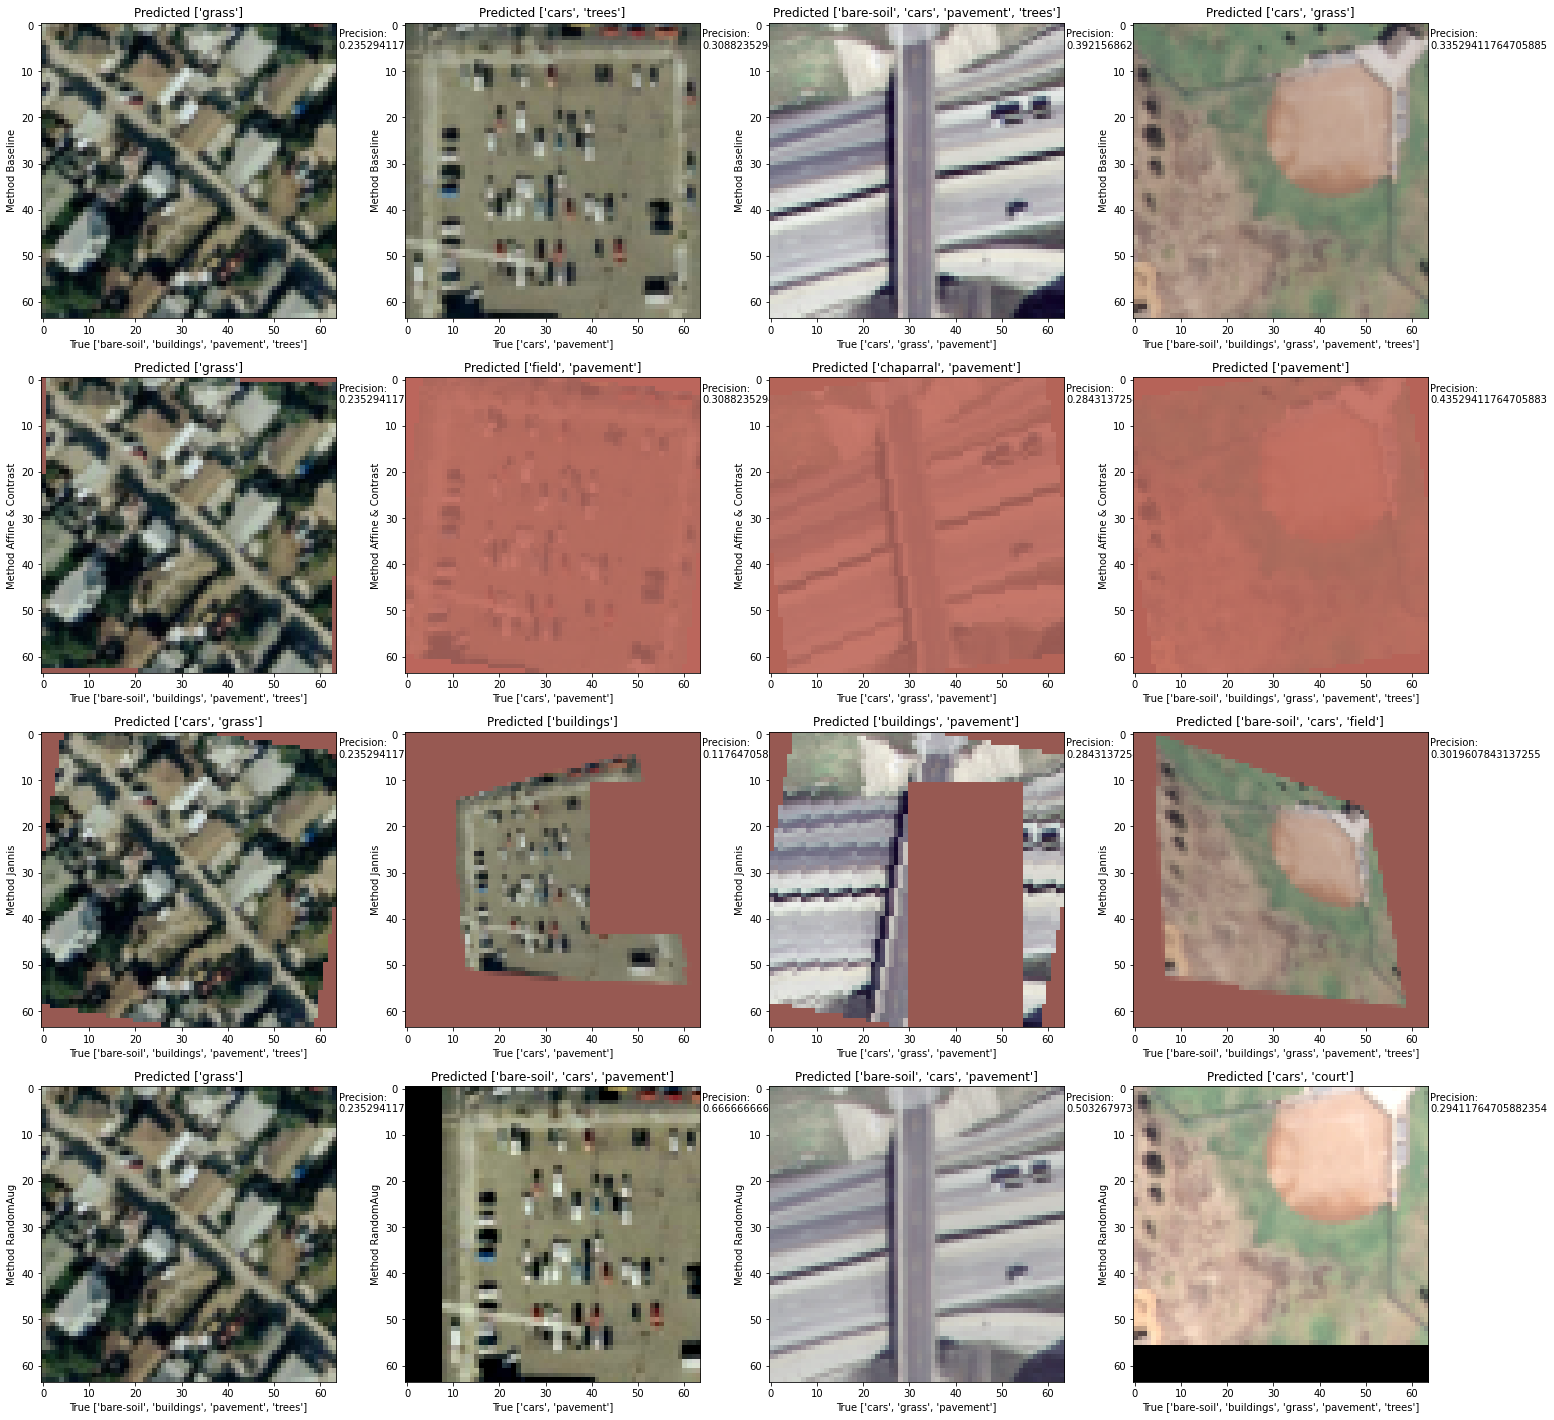

In [142]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,4,figsize=(25,25))

display_specific_image(best_model,base_test_loader,1,46,"Baseline",ax[0,0])
display_specific_image(best_model,base_test_loader,4,56,"Baseline",ax[0,1])
display_specific_image(best_model,base_test_loader,5,0,"Baseline",ax[0,2])
display_specific_image(best_model,base_test_loader,0,34,"Baseline",ax[0,3])

display_specific_image(best_model,affcont_test_loader,1,46,"Affine & Contrast",ax[1,0])
display_specific_image(best_model,affcont_test_loader,4,56,"Affine & Contrast",ax[1,1])
display_specific_image(best_model,affcont_test_loader,5,0,"Affine & Contrast",ax[1,2])
display_specific_image(best_model,affcont_test_loader,0,34,"Affine & Contrast",ax[1,3])

display_specific_image(best_model,jannis_test_loader,1,46,"Jannis",ax[2,0])
display_specific_image(best_model,jannis_test_loader,4,56,"Jannis",ax[2,1])
display_specific_image(best_model,jannis_test_loader,5,0,"Jannis",ax[2,2])
display_specific_image(best_model,jannis_test_loader,0,34,"Jannis",ax[2,3])

display_specific_image(best_model,randaug_test_loader,1,46,"RandomAug",ax[3,0])
display_specific_image(best_model,randaug_test_loader,4,56,"RandomAug",ax[3,1])
display_specific_image(best_model,randaug_test_loader,5,0,"RandomAug",ax[3,2])
display_specific_image(best_model,randaug_test_loader,0,34,"RandomAug",ax[3,3])

In [ ]:
_, report, conf_mat = val_epoch(best_model, base_test_loader, criterion, cuda_device)

In [ ]:
pretty_classification_report_print(report,mylabels)

,precision,recall,f1-score,support
airplane,0.00,0.00,0.00,16
bare-soil,0.24,0.19,0.22,149
buildings,0.27,0.29,0.28,140
cars,0.43,0.43,0.43,169
chaparral,0.44,0.42,0.43,26
court,0.04,0.06,0.05,17
dock,0.00,0.00,0.00,22
field,0.00,0.00,0.00,25
grass,0.51,0.70,0.59,195
mobile-home,0.00,0.00,0.00,23


In [ ]:
def print_performance(conf_mat)

SyntaxError: expected ':' (3842400863.py, line 1)

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_scores)

0.8333333333333333

In [ ]:
conf_mat

array([[[405,   4],
        [ 16,   0]],

       [[209,  67],
        [106,  43]],

       [[199,  86],
        [104,  36]],

       [[140, 116],
        [ 74,  95]],

       [[395,   4],
        [ 14,  12]],

       [[396,  12],
        [ 17,   0]],

       [[380,  23],
        [ 19,   3]],

       [[392,   8],
        [ 24,   1]],

       [[134,  96],
        [ 83, 112]],

       [[369,  33],
        [ 20,   3]],

       [[ 23, 146],
        [ 28, 228]],

       [[309,  56],
        [ 48,  12]],

       [[381,  24],
        [ 17,   3]],

       [[388,  14],
        [ 23,   0]],

       [[390,  13],
        [ 22,   0]],

       [[105, 117],
        [ 93, 110]],

       [[361,  23],
        [ 39,   2]]])

In [ ]:
testa = np.zeros([0,17])
testb = np.ones([64,17])
#testb.shape
testc = np.concatenate((testa,testb),axis=0)
testc.shape

(64, 17)

In [ ]:
np.zeros([1,17])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as CMD
labels = ["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks", "trees","water"]
y_thresh = np.where(y_pred>=0.5, 1., 0.)
multilabel_confusion_matrix(y_true,y_thresh).shape

(17, 2, 2)

In [ ]:
y_true = np.ones([64,17])
y_pred = np.ones([64,17])


In [ ]:
mcm = multilabel_confusion_matrix(y_true, y_pred)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
sensitivity = tp / (tp + fn)
sensitivity.round(2)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
sensitivity

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

ValueError: Must pass 2-d input. shape=(17, 2, 2)

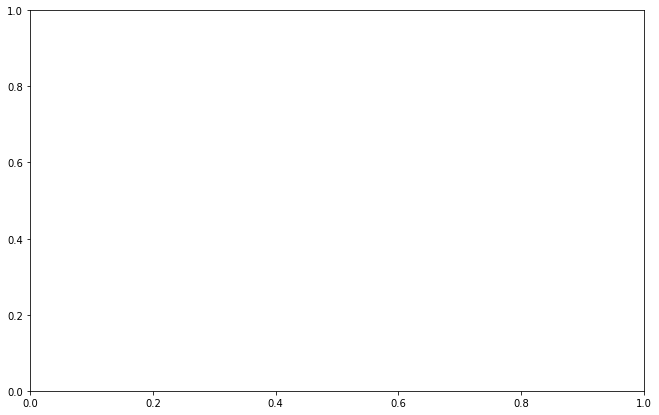

In [ ]:
prettify_confusion_matrix(mcm, class_names=mylabels)

In [ ]:
mcm

array([[[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]],

       [[ 0,  0],
        [ 0, 64]]])

In [ ]:
mcm[:].shape

(17, 2, 2)

ValueError: Must pass 2-d input. shape=(17, 2, 2)

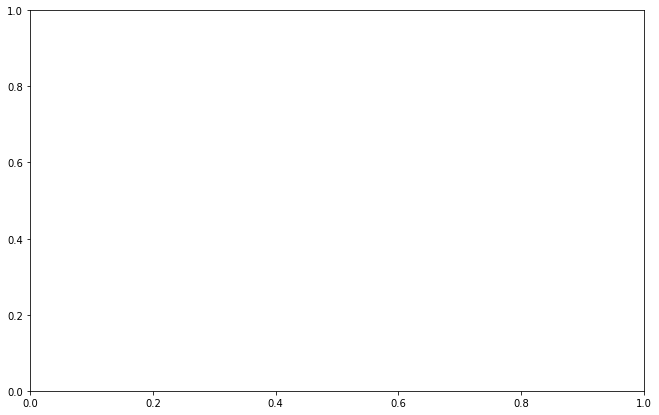

In [ ]:
prettify_confusion_matrix(mcm,labels)

In [ ]:
x = np.array()
np.vstack((x,np.ones([64,17])))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 17


Explain

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

labels =['A', 'B', 'C']

y_true = np.array([[1, 0, 1],
                   [0, 1, 0],
                   [1, 1, 1]])
y_pred = np.array([[1, 0, 0],
                   [0, 1, 1],
                   [1, 1, 1]])

print(classification_report(y_true, y_pred, target_names=labels,output_dict=True))

{'A': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'B': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'C': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2}, 'micro avg': {'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support': 6}, 'macro avg': {'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support': 6}, 'weighted avg': {'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1-score': 0.8333333333333334, 'support': 6}, 'samples avg': {'precision': 0.8333333333333334, 'recall': 0.8333333333333334, 'f1-score': 0.7777777777777777, 'support': 6}}
